In [1]:
%%time
import bayes3d as b
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import bayes3d.o3d_viz

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
CPU times: user 5.78 s, sys: 1.83 s, total: 7.61 s
Wall time: 4.86 s


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [55]:
intrinsics = b.Intrinsics(
    height=150,
    width=150,
    fx=200.0, fy=200.0,
    cx=75.0, cy=75.0,
    near=0.001, far=6.0
)

contact_plane = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 2.0, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
))


contact_poses_jit = jax.jit(
    jax.vmap(
        b.scene_graph.relative_pose_from_edge,
        in_axes=(0, None, None),
    )
)

renderer = b.Renderer(intrinsics)
cube = b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.1]))
renderer.add_mesh(cube)
table_mesh = b.mesh.make_cuboid_mesh(jnp.array([5.0, 5.0, 0.01]))

Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


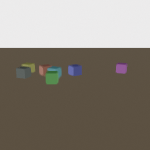

In [56]:
viz = b.o3d_viz.O3DVis(intrinsics)

poses = contact_plane @ contact_poses_jit(
        jnp.array([
        [0.0, 0.0, 1.0],
        [0.2, 0.3, 0.0],
        [0.3, 0.0, 1.0],
        [0.2, 0.1, 0.4],
        [0.5, 0.1, 0.4],
        [0.5, -0.1, 0.4],
        [-0.5, -0.1, 0.4],
    ]),
    0,
    b.utils.aabb(cube.vertices)[0]
)
colors = b.distinct_colors(len(poses))
viz.clear()

viz.make_trimesh(table_mesh, contact_plane, np.array([221, 174, 126, 255.0])/255.0)
for i in range(len(poses)):
    viz.make_trimesh(cube, poses[i], np.array([*colors[i], 1.0]))
    
rgbd = viz.capture_image(intrinsics, jnp.eye(4))
np.savez("rgbd.npz",rgbd)
b.get_rgb_image(rgbd.rgb)


In [33]:
rgbd = np.load("rgbd.npz",allow_pickle=True)["arr_0"].item()

In [57]:
observed_point_cloud_image = b.t3d.unproject_depth(rgbd.depth, intrinsics)[:,:,:3]
observed_point_cloud_image = (
    observed_point_cloud_image *
    (b.t3d.apply_transform(observed_point_cloud_image, b.t3d.inverse_pose(contact_plane))[:,:,2]>0.02)[...,None]
)
observed_point_cloud_image = b.t3d.unproject_depth(observed_point_cloud_image[:,:,2], intrinsics)
b.clear()
b.show_cloud("1", observed_point_cloud_image[:,:,:3].reshape(-1,3))

In [58]:
# observed_point_cloud_image = renderer.render_multiobject(poses, [0 for _ in range(len(poses))])[:,:,:3]
# b.clear()
# b.show_cloud("1", observed_point_cloud_image[:,:,:3].reshape(-1,3))
# b.get_depth_image(observed_point_cloud_image[:,:,2])


In [75]:
grid_params = [
    (1.0, jnp.pi, (11,11,11)), (0.6, jnp.pi/3, (11,11,11)), (0.4, jnp.pi/5, (11,11,1)),
    (0.0, jnp.pi/2, (1,1,11*11)), (0.2, jnp.pi/5, (11,11,11)), 
    (0.1, 0.0, (16,16,1)),
    (0.0, jnp.pi/10, (1,1,11*11)),
    (0.05, 0.0, (16,16,1)),
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

renderer = b.Renderer(intrinsics)
cube = b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.1]))
renderer.add_mesh(cube)

Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [82]:
# trace = Trace(
#     plane_pose[None,...], [21],
#     VARIANCE, 0.01,
#     observed_point_cloud_image
# )
VARIANCE_GRID = jnp.array([0.00001])
OUTLIER_GRID = jnp.array([ 0.000001])

trace = b.Trace(
    jnp.zeros((0,4,4)), [],
    VARIANCE_GRID[0], OUTLIER_GRID[0], 0.001,
    observed_point_cloud_image
)
b.viz_trace_meshcat(trace, renderer)

In [83]:
for _ in range(10):
    all_traces = []
    for obj_id in tqdm(range(len(renderer.meshes))):
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            traces = b.Traces(
                potential_poses, trace.ids + [obj_id], VARIANCE_GRID, OUTLIER_GRID,
                trace.outlier_volume, trace.observation
            )
            p = b.score_traces(traces, renderer)      

            ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = b.Trace(
            traces.all_poses[:,ii], traces.ids, traces.all_variances[jj],
            traces.all_outlier_prob[kk], traces.outlier_volume,
            traces.observation
        )

        all_traces.append(
            best_trace
        )


    scores = jnp.array([b.score_trace(t, renderer) for t in all_traces])
    normalized_scores = b.utils.normalize_log_scores(scores)
    print(["{:0.3f}".format(n) for n in normalized_scores])
    order = jnp.argsort(-scores)
    print(order)

    
    prev_score = b.score_trace(trace, renderer)
    new_trace = all_traces[jnp.argmax(scores)]
    print(new_trace.ids)
    new_score = b.score_trace(new_trace, renderer)
    score_delta = new_score - prev_score
    print(score_delta)
    if score_delta < 10.0:
        print("Done parsing")
        break
    
    trace = new_trace
    b.viz_trace_meshcat(trace, renderer)
    
b.viz_trace_meshcat(trace, renderer)


100%|█████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


['1.000']
[0]
[0]
923.0625


100%|█████████████████████████████| 1/1 [00:00<00:00,  5.47it/s]


['1.000']
[0]
[0, 0]
0.0
Done parsing


In [84]:
b.viz_trace_meshcat(new_trace, renderer)
